In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
sys.path.append('/content/drive/MyDrive')
import helper as hp

# MLP

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from keras.models import Sequential
from keras import regularizers
from keras.layers import Dense, BatchNormalization, Dropout, Flatten, Activation
from keras.optimizers import Adam, RMSprop, SGD, Adagrad, Adadelta, Adamax, Nadam
from keras.metrics import SensitivityAtSpecificity
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, Callback
from keras.utils import np_utils
import keras.backend as K
from keras import Model
import datetime

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_curve, auc, roc_auc_score
from itertools import cycle


In [5]:
from keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']




### Sparse arrays

In [6]:
y_sparse_train = np.zeros([len(y_train),10])
y_sparse_test = np.zeros([len(y_test),10])
for idx in range(len(y_train)):
    y_sparse_train[idx,y_train[idx]] = 1

for idx in range(len(y_test)):
    y_sparse_test[idx,y_test[idx]] = 1

## 4 Hidden layers

We add a 2 nodes layer at the end.

In [14]:
K.clear_session()

model_4_hidden = Sequential()
model_4_hidden.add(Flatten(input_shape=(28,28)))
model_4_hidden.add(BatchNormalization())
model_4_hidden.add(Dense(512, activation = 'relu', kernel_initializer = 'random_normal'))
model_4_hidden.add(Dropout(0.125))
model_4_hidden.add(Dense(128, activation = 'relu', kernel_initializer = 'random_normal'))
model_4_hidden.add(Dropout(0.125))
model_4_hidden.add(Dense(64, activation = 'relu', kernel_initializer = 'random_normal'))
model_4_hidden.add(Dropout(0.125))
model_4_hidden.add(Dense(2, activation = 'relu', kernel_initializer = 'random_normal'))
model_4_hidden.add(Dense(10, activation='softmax', kernel_initializer='random_normal', name='Output'))

model_4_hidden.summary()

model_4_hidden.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

In [15]:
model_trained_4 = model_4_hidden.fit(x_train,
                                  y_sparse_train,
                                  epochs=512, batch_size=128,
                                  verbose=1,
                                  validation_data = (x_test, y_sparse_test),
                                  callbacks=[hp.callback_EarlyStopping()],
                                )

Epoch 1/512
469/469 [==============================] - 9s 5ms/step - loss: 1.1346 - accuracy: 0.5338 - val_loss: 0.7991 - val_accuracy: 0.6966
Epoch 2/512
469/469 [==============================] - 2s 4ms/step - loss: 0.7509 - accuracy: 0.7210 - val_loss: 0.7503 - val_accuracy: 0.7212
Epoch 3/512
469/469 [==============================] - 2s 4ms/step - loss: 0.6566 - accuracy: 0.7634 - val_loss: 0.6698 - val_accuracy: 0.7729
Epoch 4/512
469/469 [==============================] - 2s 5ms/step - loss: 0.6111 - accuracy: 0.7801 - val_loss: 0.6249 - val_accuracy: 0.7840
Epoch 5/512
469/469 [==============================] - 3s 7ms/step - loss: 0.5356 - accuracy: 0.8236 - val_loss: 0.5419 - val_accuracy: 0.8391
Epoch 6/512
469/469 [==============================] - 2s 5ms/step - loss: 0.4806 - accuracy: 0.8474 - val_loss: 0.5307 - val_accuracy: 0.8430
Epoch 7/512
469/469 [==============================] - 2s 5ms/step - loss: 0.4473 - accuracy: 0.8579 - val_loss: 0.4919 - val_accuracy: 0.8543

In [16]:
model_best_input = Model(inputs=model_4_hidden.input, outputs=model_4_hidden.layers[-2].output)
model_best_input.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_input (InputLayer)  [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                             

In [17]:
model_best_output = Model(inputs=model_4_hidden.layers[-1].input, outputs=model_4_hidden.layers[-1].output)
model_best_output.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 Output (Dense)              (None, 10)                30        
                                                                 
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________


313/313 [==============================] - 0s 1ms/step


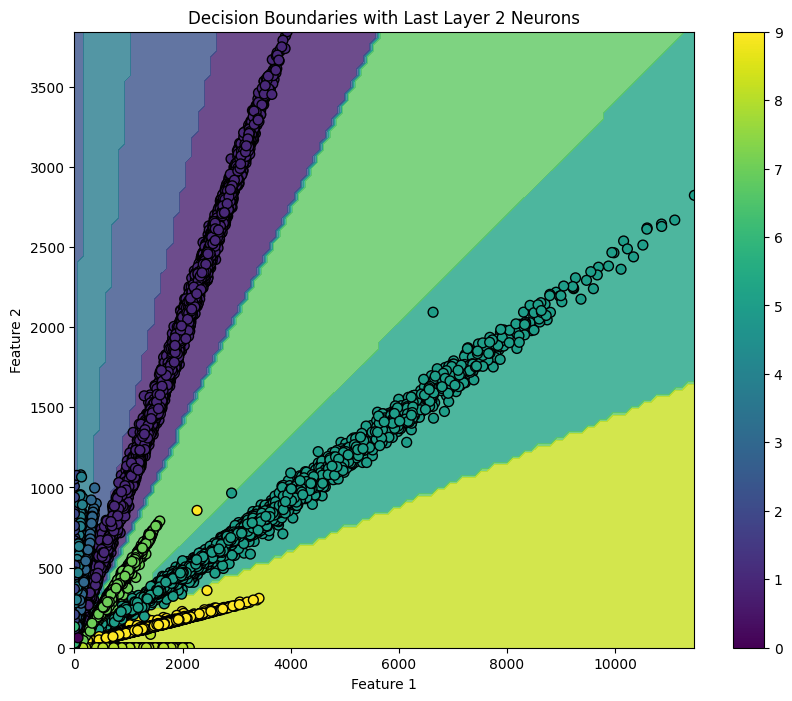

In [18]:
x_train_2 = model_best_input.predict(x_train)


x_min, x_max = x_train_2[:, 0].min() - 0.1, x_train_2[:, 0].max() + 0.1
y_min, y_max = x_train_2[:, 1].min() - 0.1, x_train_2[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

# Flatten the meshgrid coordinates and make predictions
meshgrid_data = np.c_[xx.ravel(), yy.ravel()]
predictions = model_best_output.predict(meshgrid_data)

# Reshape the predictions and create a contour plot
predictions = np.argmax(predictions, axis=1)
predictions = predictions.reshape(xx.shape)
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, predictions, alpha=0.8)
plt.scatter(x_train_2[:, 0], x_train_2[:, 1], c=y_train, edgecolors='k', s=50)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Boundaries with Last Layer 2 Neurons')
plt.colorbar()
plt.show()